# Nootebok description

In this script **local models** for each water table sensor are trained.  The seq2val (many-to-one) scenario is considered, in which *T* past weeks of weather raster images are used to predict the water table depth at a time step *t*

For these aim hybrid models are considered, in which the first part is a Time Distributed CNN (TDC) and then second part is a sequential model. Here 2 types of sequential models are compared: The first based on a ***LSTM*** layer; the second based on the ***UnPWaveNet*** which is a new proposed verios of the WaveNet for outputing sequence shorter and completely shifted in the future (no causal constraint) .

This script has been used for manual grid search of the hyperparameter and for building the architectures. While the same architecture are adopted identically for each sensors, the hyperparameters are tuned for each local model.

***PS: also in this case, all the procedures and functions have been built in a general way adaptable for a many-to-many scenario***  

In [ ]:
!python --version # Python 3.10.12

Python 3.10.12


# Libraries, Settings, and Directories

In [ ]:
!pip install numpy==1.25.2
!pip install rioxarray==0.15.5
!pip install matplotlib==3.7.1
!pip install xarray==2023.7.0
!pip install netCDF4==1.6.5
!pip install pandas==2.0.3
!pip install seaborn==0.13.1
!pip install rasterio==1.3.10
!pip install imageio==2.31.6
!pip install geopandas==0.13.2
!pip install cmasher==1.8.0
!pip install scipy==1.11.4
!pip install cftime==1.6.3
!pip install tensorflow==2.15.0 # cuDNN 8.9	CUDA 12.2 # keras 2.15.0
!pip install great-circle-calculator==1.3.1
!pip install matplotlib_scalebar==0.8.1
!pip install adjustText==1.1.1
!pip install geopy==2.4.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.3/533.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.3 MB/s eta 0:00:00
  Attempting uninstall: cftime
    Found existing installation: cftime 1.6.4
    Uninstalling cftime-1.6.4:
      Successfully uninstalled cftime-1.6.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: geopy
    Found existing installation: geopy 2.3.0
    Uninstalling geopy-2.3.0:
      Successfully uninstalled geopy-2.3.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import xarray
import rioxarray
from netCDF4 import num2date
import rasterio
from rasterio.plot import show
import pandas as pd
import copy
import datetime
from datetime import datetime, timedelta
import seaborn as sns
import geopandas as gpd
import datetime
import os
from itertools import compress
import random
import re
import math
import gc
import scipy.stats
import warnings

from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
import sys
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import load_model
import pickle

tf.keras.backend.clear_session()

In [ ]:
# keras.__version__
# !pip show keras

In [ ]:
!nvcc --version #release 12.2, V12.2.140

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [ ]:
#Check if a GPU is available and used
try:
  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found at :0')
  print('Found GPU at: {}'.format(device_name))
  gpu = True
except SystemError:
  print("No GPU found...\n")
  gpu = False

No GPU found...



In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
# Import modules
sys.path.append('/.../python_modules/')

from data_handle import *
from plot_functions import *
from models_creation import *
from models_training_testing import *

## General settings

In [ ]:
# select the temporal frequency:
temp_freq = "W"
step_ahead = 0 # 0 means seq2val; >0 means seq2seq
past_meteo_images = 104 # 104 weeks means two years
focus_on_sensors = "Racconigi_00417910001"
# Available sensors:
#  'Racconigi_00417910001',
#  'Savigliano_00421510001',
#  'Vottignasco_00425010001'

In [ ]:
# To automatic define directories
# output_type
if (step_ahead > 0):
  output_type = "seq2seq"
else:
  output_type = "seq2val"

# input sequence
if (past_meteo_images == 104):
  input_sequence_length = "2Y"

## Directories

In [ ]:
## Define your directories

data_path = "/.../Datasets/"
## subfolder in /datasets
splits_target_objects_main_path = f"{data_path}training_validation_test_sets_{input_sequence_length}/target_water_table_depth/"
# target data splitted into training validation and test - ready for deep learning models
splits_target_numpy_objects_path = f"{data_path}training_validation_test_sets_{input_sequence_length}/target_water_table_depth/{output_type}/"

# weather data splitted into training validation and test - ready for deep learning models
splits_features_objects_main_path = f"{data_path}training_validation_test_sets_{input_sequence_length}/features_meteorological_variables/"
# weather data not splitted
unsplitted_features_path = f"{data_path}pre_processed_meteoOI_ARPA_Grana_Maira/"

# directory for model log and saving trained parameters
log_path = "/.../Scripts/logs_weekly_models/local_models/"
log_path = f"{log_path}{output_type}/training2016_validation_2022test"

# results saving path
results_path = "/.../Results/water_table_Grana_Maira/"
results_path_output_type = f"{results_path}training2016_validation_2022test/{output_type}/"

# Import data

## Target: Water Table Depth

#### DataFrame

In [ ]:
## Load full series with gaps introduced due to splitting
files_target_main_path = os.listdir(splits_target_objects_main_path)

target_splited_ds_file = [re.search(f'.*{focus_on_sensors}.*(.csv)$', files_target_main_path[i]) for i in range(len(files_target_main_path))]
target_splited_ds_file = [files_target_main_path[i] for i in range(len(target_splited_ds_file)) if target_splited_ds_file[i] is not None]; target_splited_ds_file

['Racconigi_00417910001_training_target_ds.csv',
 'Racconigi_00417910001_validation_target_ds.csv',
 'Racconigi_00417910001_test_target_ds.csv',
 'Racconigi_00417910001_all_sets_target_ds.csv']

In [ ]:
water_table_depth_training_ds = pd.read_csv(f"{splits_target_objects_main_path}{focus_on_sensors}_training_target_ds.csv", dtype={"ID_code":'str'})
water_table_depth_training_ds = water_table_depth_training_ds.astype({"Date":'datetime64[ns]'})

water_table_depth_validation_ds = pd.read_csv(f"{splits_target_objects_main_path}{focus_on_sensors}_validation_target_ds.csv", dtype={"ID_code":'str'})
water_table_depth_validation_ds = water_table_depth_validation_ds.astype({"Date":'datetime64[ns]'})

water_table_depth_test_ds = pd.read_csv(f"{splits_target_objects_main_path}{focus_on_sensors}_test_target_ds.csv", dtype={"ID_code":'str'})
water_table_depth_test_ds = water_table_depth_test_ds.astype({"Date":'datetime64[ns]'})

water_table_depth_all_sets_ds = pd.read_csv(f"{splits_target_objects_main_path}{focus_on_sensors}_all_sets_target_ds.csv", dtype={"ID_code":'str'})
water_table_depth_all_sets_ds = water_table_depth_all_sets_ds.astype({"Date":'datetime64[ns]'})

In [ ]:
water_table_depth_training_ds

,Date,ID_code,Value
0,2001-01-14,00417910001,4.100952
1,2001-01-21,00417910001,4.127381
2,2001-01-28,00417910001,4.195714
3,2001-02-04,00417910001,4.258333
4,2001-02-11,00417910001,4.336667
...,...,...,...
744,2015-11-29,00417910001,4.490000
745,2015-12-06,00417910001,4.496667
746,2015-12-13,00417910001,4.499524
747,2015-12-20,00417910001,4.500952


In [ ]:
sensor_id = water_table_depth_training_ds["ID_code"].unique()[0]; sensor_id

'00417910001'

In [ ]:
water_table_depth_training_ds.dtypes

Date       datetime64[ns]
ID_code            object
Value             float64
dtype: object

In [ ]:
# Write Municipality and ID Code for plot titles
sensor_municipality_id = focus_on_sensors.replace("_"," ")
sensor_municipality_id

'Racconigi 00417910001'

In [ ]:
sensor_municipality = " ".join(re.findall("[a-zA-Z]+", sensor_municipality_id))
sensor_municipality

'Racconigi'

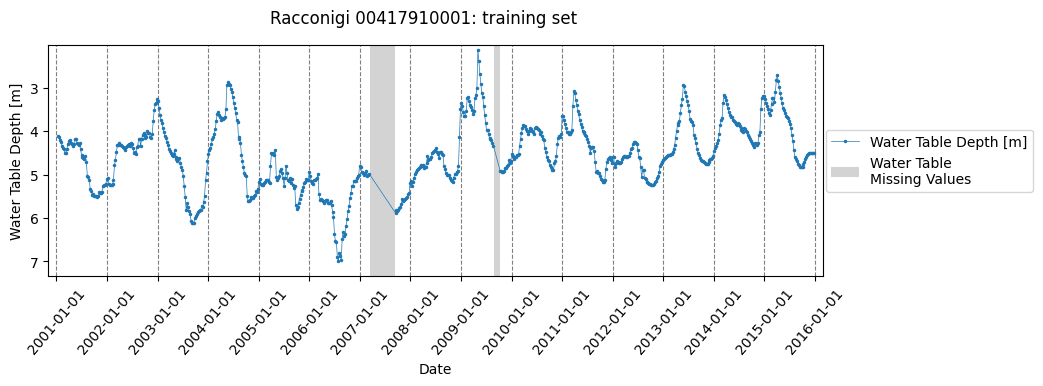

In [ ]:
plot_ts_with_gaps(y = water_table_depth_training_ds["Value"].values,
                  date = water_table_depth_training_ds["Date"].values,
                  label_base_series = "Water Table Depth [m]",
                  title = sensor_municipality_id + ": training set", width = 10,
                  height = 3, temp_freq='W', y_lim = 0.05, linewidth = 0.5, x_legend = 1.28)

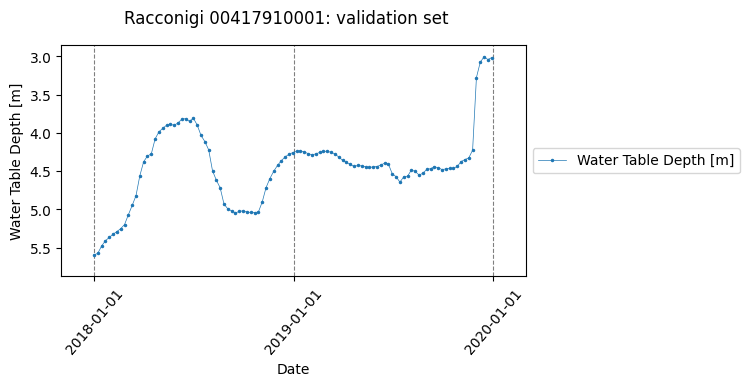

In [ ]:
plot_ts_with_gaps(y = water_table_depth_validation_ds["Value"].values,
                  date = water_table_depth_validation_ds["Date"].values,
                  label_base_series = "Water Table Depth [m]",
                  title = sensor_municipality_id + ": validation set", width = 6,
                  height = 3, temp_freq='W', y_lim = 0.05, linewidth = 0.5, x_legend = 1.475)

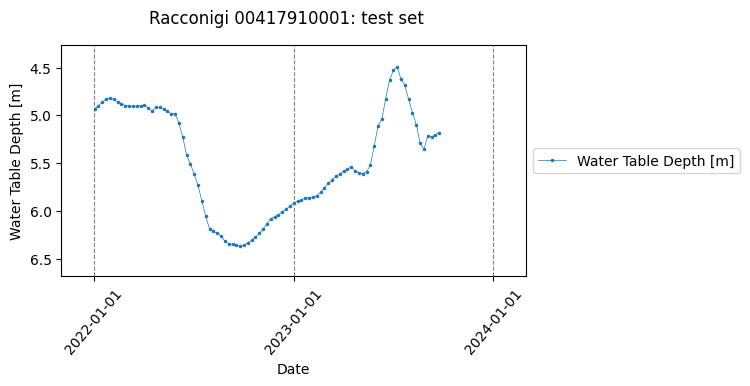

In [ ]:
plot_ts_with_gaps(y = water_table_depth_test_ds["Value"].values,
                  date = water_table_depth_test_ds["Date"].values,
                  label_base_series = "Water Table Depth [m]",
                  title = sensor_municipality_id + ": test set", width = 6,
                  height = 3, temp_freq='W', y_lim = 0.05, linewidth = 0.5, x_legend = 1.475)

#### Model Output objects

In [ ]:
files_target_numpy = os.listdir(splits_target_numpy_objects_path)

target_splited_numpy_file = [re.search(f'.*{focus_on_sensors}.*', files_target_numpy[i]) for i in range(len(files_target_numpy))]
target_splited_numpy_file = [files_target_numpy[i] for i in range(len(target_splited_numpy_file)) if target_splited_numpy_file[i] is not None]
target_splited_numpy_file

['Racconigi_00417910001_training_target_values.npy',
 'Racconigi_00417910001_training_target_normalized_values.npy',
 'Racconigi_00417910001_training_target_dates.npy',
 'Racconigi_00417910001_validation_target_values.npy',
 'Racconigi_00417910001_validation_target_normalized_values.npy',
 'Racconigi_00417910001_validation_target_dates.npy',
 'Racconigi_00417910001_test_target_values.npy',
 'Racconigi_00417910001_test_target_normalized_values.npy',
 'Racconigi_00417910001_test_target_dates.npy']

In [ ]:
### Load splited numpy objects (the actual output of the following models)

## Training
water_table_depth_training_values = np.load(f"{splits_target_numpy_objects_path}{focus_on_sensors}_training_target_values.npy")
water_table_depth_training_normalized_values = np.load(f"{splits_target_numpy_objects_path}{focus_on_sensors}_training_target_normalized_values.npy")

## Validation
water_table_depth_validation_values = np.load(f"{splits_target_numpy_objects_path}{focus_on_sensors}_validation_target_values.npy")
water_table_depth_validation_normalized_values = np.load(f"{splits_target_numpy_objects_path}{focus_on_sensors}_validation_target_normalized_values.npy")

## Test
water_table_depth_test_values = np.load(f"{splits_target_numpy_objects_path}{focus_on_sensors}_test_target_values.npy")
water_table_depth_test_normalized_values = np.load(f"{splits_target_numpy_objects_path}{focus_on_sensors}_test_target_normalized_values.npy")

#### Normalization factors

In [ ]:
files_target_main_path = os.listdir(splits_target_objects_main_path)

target_normalization_factors_file = [re.search(f'.*{focus_on_sensors}.*(.npy)$', files_target_main_path[i]) for i in range(len(files_target_main_path))]
target_normalization_factors_file = [files_target_main_path[i] for i in range(len(target_normalization_factors_file)) if target_normalization_factors_file[i] is not None]; target_normalization_factors_file

['Racconigi_00417910001_training_target_mean.npy',
 'Racconigi_00417910001_training_target_std.npy']

In [ ]:
water_table_depth_training_mean = np.load(f"{splits_target_objects_main_path}{focus_on_sensors}_training_target_mean.npy")
water_table_depth_training_std = np.load(f"{splits_target_objects_main_path}{focus_on_sensors}_training_target_std.npy")

In [ ]:
print("Training mean[m]:", water_table_depth_training_mean)

Training mean[m]: 4.540472906907098


In [ ]:
print("Training standard deviation[m]:", water_table_depth_training_std)

Training standard deviation[m]: 0.7611342140269624


## Features: Meteorological variables

### Model Input objects

In [ ]:
files_features_main_path = os.listdir(splits_features_objects_main_path)

features_splited_numpy_file = [re.search(f'.*{focus_on_sensors}.*(.npy)$', files_features_main_path[i]) for i in range(len(files_features_main_path))]
features_splited_numpy_file = [files_features_main_path[i] for i in range(len(features_splited_numpy_file)) if features_splited_numpy_file[i] is not None]; features_splited_numpy_file

['Racconigi_00417910001_training_image_sequences.npy',
 'Racconigi_00417910001_training_image_sequences_dates.npy',
 'Racconigi_00417910001_training_normalized_image_sequences.npy',
 'Racconigi_00417910001_training_month_OHE.npy',
 'Racconigi_00417910001_validation_image_sequences.npy',
 'Racconigi_00417910001_validation_normalized_image_sequences.npy',
 'Racconigi_00417910001_validation_image_sequences_dates.npy',
 'Racconigi_00417910001_validation_month_OHE.npy',
 'Racconigi_00417910001_test_image_sequences.npy',
 'Racconigi_00417910001_test_normalized_image_sequences.npy',
 'Racconigi_00417910001_test_image_sequences_dates.npy',
 'Racconigi_00417910001_test_month_OHE.npy']

In [ ]:
## Training
meteorological_training_input_sequences_normalized = np.load(f"{splits_features_objects_main_path}{focus_on_sensors}_training_normalized_image_sequences.npy")
month_OHE_training = np.load(f"{splits_features_objects_main_path}{focus_on_sensors}_training_month_OHE.npy")

## Validation
meteorological_validation_input_sequences_normalized = np.load(f"{splits_features_objects_main_path}{focus_on_sensors}_validation_normalized_image_sequences.npy")
month_OHE_validation = np.load(f"{splits_features_objects_main_path}{focus_on_sensors}_validation_month_OHE.npy")

## Test
meteorological_test_input_sequences_normalized = np.load(f"{splits_features_objects_main_path}{focus_on_sensors}_test_normalized_image_sequences.npy")
month_OHE_test = np.load(f"{splits_features_objects_main_path}{focus_on_sensors}_test_month_OHE.npy")

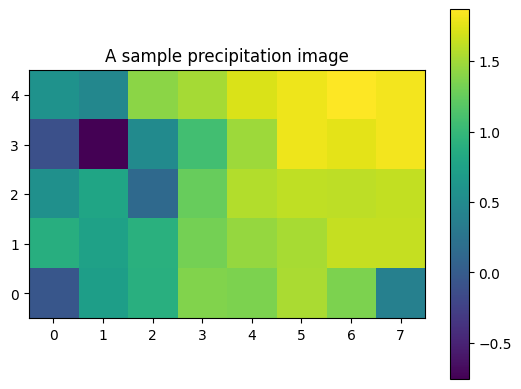

In [ ]:
plt.imshow(meteorological_training_input_sequences_normalized[-1,23,:,:,1], cmap = 'viridis', origin="lower")
plt.title("A sample precipitation image")
plt.colorbar()

### Normalization factors

In [ ]:
iles_features_main_path = os.listdir(splits_features_objects_main_path)

features_netcdf_file = [re.search(f'.*{focus_on_sensors}.*(.nc)$', files_features_main_path[i]) for i in range(len(files_features_main_path))]
features_netcdf_file = [files_features_main_path[i] for i in range(len(features_netcdf_file)) if features_netcdf_file[i] is not None]; features_netcdf_file

['Racconigi_00417910001_training_meteorological_means.nc',
 'Racconigi_00417910001_training_meteorological_std.nc',
 'Racconigi_00417910001_training_meteorological_features_ds.nc',
 'Racconigi_00417910001_validation_meteorological_features_ds.nc',
 'Racconigi_00417910001_test_meteorological_features_ds.nc']

In [ ]:
meteorological_training_means_ds = xarray.open_dataset(f"{splits_features_objects_main_path}{focus_on_sensors}_training_meteorological_means.nc")
meteorological_training_std_ds = xarray.open_dataset(f"{splits_features_objects_main_path}{focus_on_sensors}_training_meteorological_std.nc")

In [ ]:
meteorological_training_means_ds["prec"].values

array(2.5644202, dtype=float32)

In [ ]:
meteorological_training_means_ds["tmax"].values

array(282.72906, dtype=float32)

In [ ]:
meteorological_training_means_ds["tmin"].values

array(282.72906, dtype=float32)

### Weekly Mean Precipitations

In [ ]:
# Useful in plots
weekly_mean_precipitations = pd.read_csv(f"{unsplitted_features_path}weekly_mean_precipitations_GM.csv")
weekly_mean_precipitations = weekly_mean_precipitations.astype({"Date":'datetime64[ns]'})
weekly_mean_precipitations

,prec,Date
0,0.001065,1990-01-07
1,0.000000,1990-01-14
2,0.000000,1990-01-21
3,0.279988,1990-01-28
4,0.678878,1990-02-04
...,...,...
1781,1.194062,2024-02-25
1782,21.381340,2024-03-03
1783,9.854746,2024-03-10
1784,0.824634,2024-03-17


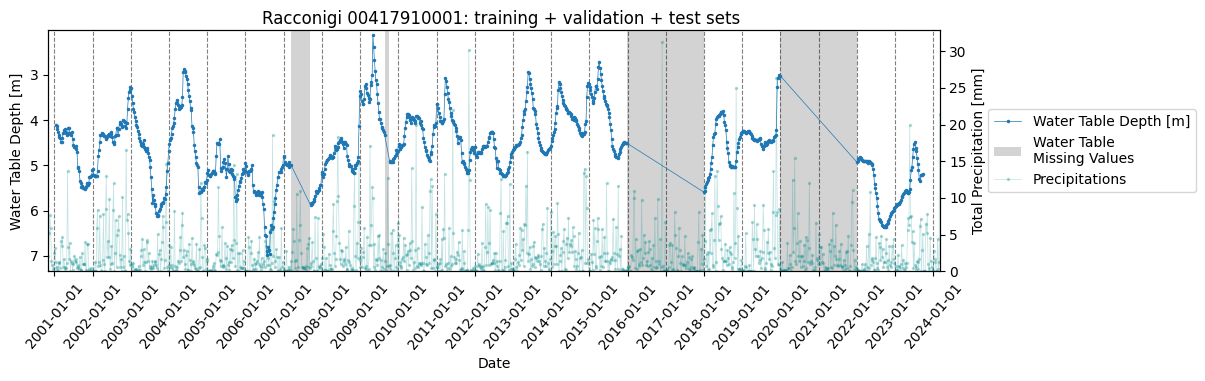

In [ ]:
plot_ts_with_gaps(y = water_table_depth_all_sets_ds["Value"].values,
                  date = water_table_depth_all_sets_ds["Date"].values,
                  label_base_series = "Water Table Depth [m]",
                  title = sensor_municipality_id + ": training + validation + test sets", width = 10,
                  height = 3, temp_freq='W', y_lim = 0.05, linewidth = 0.5, x_legend = 1.295,
                  precipitations=weekly_mean_precipitations["prec"].values,
                  date_precipitations = weekly_mean_precipitations["Date"].values)

# Model initialization & training

## Model Initializations

Initialize the desired model

In [ ]:
# Log saving folder
log_path

### Exogenous Seq2Val models
Input: present and past meteorological data

Output: water table depth at the next time step

#### Time distributed UnPWaveNet

In [ ]:
tf.keras.backend.clear_session()
kernel_regularization_unpwavenet = 0.0075
perc_dropout_hidden_series = 0.15
channels_dilated_conv = 32
channels_1x1conv = 8
gated_activation = True

exo_model_meteo_seq2val_time_dist_unpwavenet = meteo_model_time_dist_dilated_unpwavenet(output_neurons = 1,
                        past_meteorological_images = past_meteo_images,
                        input_month_encodings = True,
                        dropout = "classic",
                        perc_dropout = perc_dropout_hidden_series,
                        channels_dilated_conv = channels_dilated_conv,
                        kernel_dilated_conv = 4,
                        channels_1x1conv = channels_1x1conv,
                        gated_activation = gated_activation,
                        kernel_regularizer = tf.keras.regularizers.L2(kernel_regularization_unpwavenet),
                        kernel_regularizer_dilated_conv = tf.keras.regularizers.L2(kernel_regularization_unpwavenet),
                        kernel_regularizer_1x1_conv = tf.keras.regularizers.L2(kernel_regularization_unpwavenet),
                        bias_regularizer = None,
                        bias_regularizer_dilated_conv = None,
                        bias_regularizer_1x1_conv = None)

exo_model_meteo_seq2val_time_dist_unpwavenet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 104, 5, 8, 3)]       0         []                            
                                                                                                  
 time_distributed (TimeDist  (None, 104, 5, 8, 8)         104       ['input_1[0][0]']             
 ributed)                                                                                         
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 104, 5, 8, 8)         0         ['time_distributed[0][0]']    
                                                                                                  
 time_distributed_1 (TimeDi  (None, 104, 5, 8, 16)        528       ['leaky_re_lu[0][0]']     

In [ ]:
# Plot the architecture
# architecture_file_name = f'{log_path}/exo_meteo_seq2val_time_distributed_unpwavenet.png'
# keras.utils.plot_model(exo_model_meteo_seq2val_time_dist_unpwavenet, to_file = architecture_file_name)

#### Time distributed LSTM

In [ ]:
tf.keras.backend.clear_session()
kernel_regularization_lstm = 0.005
perc_dropout_lstm = 0.15
lstm_units = 32
lstm_activation = "leaky_relu"

exo_model_meteo_seq2val_time_dist_lstm = meteo_model_time_dist_dilated_lstm(output_neurons = 1,
                                    lstm_units = lstm_units,
                                    input_month_encodings = True,
                                    past_meteorological_images = past_meteo_images,
                                    lstm_activation = lstm_activation,
                                    dropout = "classic",
                                    perc_dropout = perc_dropout_lstm,
                                    kernel_regularizer = tf.keras.regularizers.L2(kernel_regularization_lstm),
                                    kernel_regularizer_lstm = tf.keras.regularizers.L2(kernel_regularization_lstm),
                                    bias_regularizer = None,
                                    bias_regularizer_lstm = None,
                                    recurrent_regularizer_lstm = tf.keras.regularizers.L2(kernel_regularization_lstm))

exo_model_meteo_seq2val_time_dist_lstm.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 104, 5, 8, 3)]       0         []                            
                                                                                                  
 time_distributed (TimeDist  (None, 104, 5, 8, 8)         104       ['input_1[0][0]']             
 ributed)                                                                                         
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 104, 5, 8, 8)         0         ['time_distributed[0][0]']    
                                                                                                  
 time_distributed_1 (TimeDi  (None, 104, 5, 8, 16)        528       ['leaky_re_lu[0][0]']     

In [ ]:
# Plot the architecture
# keras.utils.plot_model(exo_model_meteo_seq2val_time_dist_lstm, to_file = f'{log_path}/exo_meteo_seq2val_time_distributed_LSTM.png')

## Training

### Exogenous Seq2val models

#### Time distributed unpwavenet

In [ ]:
batch = 8
nepochs = 80
lr = 0.001
clipnorm = 1.0

In [ ]:
# Define the name of the logs and object to be saved
base_name = f"{focus_on_sensors}_{input_sequence_length}_time_dist_unpwavenet_{channels_dilated_conv}_{channels_1x1conv}"
print(base_name)
model_folder_name = f"{base_name}_lr{lr}_L2reg{kernel_regularization_unpwavenet}_CN{clipnorm}_{nepochs}_{batch}"
model_folder_name = "GPU_" + model_folder_name if gpu is True else model_folder_name
print(model_folder_name)

In [ ]:
# Compile the model
logdir, filename_model, filename_weights, filename_hist =  setting_model(exo_model_meteo_seq2val_time_dist_unpwavenet,
                  models_dir = log_path,
                  optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9,  nesterov=True, clipnorm=clipnorm),
                  new_folder_name = model_folder_name, initial_epoch = 0, logdir = None,
                  loss = 'mean_squared_error', metrics = ['mean_squared_error'],
                  model_name = base_name, history_name = base_name)

In [ ]:
gc.collect()

48879

In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)
%tensorboard --logdir={logdir}

In [ ]:
# For saving every 100 epochs (not needed if epochs left at 80)
save_freq = math.ceil((len(water_table_depth_training_ds)/batch))*100;  save_freq

2400

In [ ]:
history_exo_model_meteo_seq2val_time_dist_unpwavenet = train_model(exo_model_meteo_seq2val_time_dist_unpwavenet,
                x_train = [meteorological_training_input_sequences_normalized, month_OHE_training],
                y_train = water_table_depth_training_normalized_values,
                x_val = [meteorological_validation_input_sequences_normalized, month_OHE_validation],
                y_val = water_table_depth_validation_normalized_values,
                epochs = nepochs, batch_size = batch, initial_epoch = 0,
                tensorboard_callback = tensorboard_callback,
                filename_model = filename_model,
                filename_weights = filename_weights,
                filename_hist = filename_hist,
                save = True,  save_freq = save_freq,
                shuffle = True)

#### Time distributed LSTM

In [ ]:
batch = 8
nepochs = 80
lr = 0.001
clipnorm = 1.0

In [ ]:
# Define the name of the logs and object to be saved
base_name = f"{focus_on_sensors}_{input_sequence_length}_time_dist_1LSTM_{lstm_units}_{lstm_activation}"
print(base_name)
model_folder_name = f"{base_name}_lr{lr}_L2reg{kernel_regularization_lstm}_CN{clipnorm}_{nepochs}_{batch}"
model_folder_name = "GPU_" + model_folder_name if gpu is True else model_folder_name
print(model_folder_name)

Racconigi_00417910001_2Y_time_dist_1LSTM_32_leaky_relu_BN_HeUniform
Racconigi_00417910001_2Y_time_dist_1LSTM_32_leaky_relu_BN_HeUniform_lr0.0025_L2reg0.0025_CN0.5_64_8


In [ ]:
# Compile the model
logdir, filename_model, filename_weights, filename_hist =  setting_model(exo_model_meteo_seq2val_time_dist_lstm,
                  models_dir = log_path,
                  optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9 , nesterov=True, clipnorm=clipnorm),
                  new_folder_name = model_folder_name, initial_epoch = 0, logdir = None,
                  loss = 'mean_squared_error', metrics = ['mean_squared_error'],
                  model_name = base_name, history_name = base_name)

In [ ]:
gc.collect()

40856

In [ ]:
%load_ext tensorboard

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)
%tensorboard --logdir={logdir}

In [ ]:
# For saving every 100 epochs (not needed if epochs left at 80)
save_freq = math.ceil((len(water_table_depth_training_ds)/batch))*100;  save_freq

In [ ]:
history_exo_model_meteo_seq2val_time_dist_lstm = train_model(exo_model_meteo_seq2val_time_dist_lstm,
                x_train = [meteorological_training_input_sequences_normalized, month_OHE_training],
                y_train = water_table_depth_training_normalized_values,
                x_val = [meteorological_validation_input_sequences_normalized, month_OHE_validation],
                y_val = water_table_depth_validation_normalized_values,
                epochs = nepochs, batch_size = batch, initial_epoch = 0,
                tensorboard_callback = tensorboard_callback,
                filename_model = filename_model,
                filename_weights = filename_weights,
                filename_hist = filename_hist,
                save = True,  save_freq = save_freq)

In [ ]:
gc.collect()

1420

# Predictions and evaluations

In [ ]:
# For loading a pre-trained models:

# class doprout_custom(tf.keras.layers.SpatialDropout1D):
#       def call(self, inputs, training):
#         return super().call(inputs, training)
# exo_model_meteo_seq2val_time_dist_unpwavenet = keras.models.load_model('/.../model.keras',
#                                                                   custom_objects={"doprout_custom": doprout_custom})

# exo_model_meteo_seq2val_time_dist_lstm = keras.models.load_model('/.../model.keras',
#                                                                    custom_objects={"doprout_custom": doprout_custom})

In [ ]:
gc.collect()

1430

In [ ]:
model_names = ["UnPWaveNet"] # , "UnPWaveNet" "LSTM"

In [ ]:
model_colors = ["tab:orange"] # , "tab:orange" "darkred"

In [ ]:
all_models = [exo_model_meteo_seq2val_time_dist_unpwavenet,
              exo_model_meteo_seq2val_time_dist_lstm]

In [ ]:
# Build input and output object for each local model
all_training_features = [[meteorological_training_input_sequences_normalized, month_OHE_training] for i in range(len(all_models))]
all_validation_features = [[meteorological_validation_input_sequences_normalized, month_OHE_validation]  for i in range(len(all_models))]
all_test_features = [[meteorological_test_input_sequences_normalized, month_OHE_test] for i in range(len(all_models))]

In [ ]:
# Make the predictions
all_target_predictions_training = [all_models[i].predict(all_training_features[i]) for i in range(0,len(all_training_features))]
all_target_predictions_validation = [all_models[i].predict(all_validation_features[i]) for i in range(0,len(all_validation_features))]
all_target_predictions_test = [all_models[i].predict(all_test_features[i]) for i in range(0,len(all_test_features))]

In [ ]:
# Re-scale to the original range
all_target_predictions_training = [(all_target_predictions_training[i] * water_table_depth_training_std)+ water_table_depth_training_mean for i in range(len(all_target_predictions_training))]
all_target_predictions_validation = [(all_target_predictions_validation[i] * water_table_depth_training_std) + water_table_depth_training_mean for i in range(len(all_target_predictions_validation))]
all_target_predictions_test = [(all_target_predictions_test[i] * water_table_depth_training_std) + water_table_depth_training_mean for i in range(len(all_target_predictions_test))]

## Metrics

Training

In [ ]:
# Training evaluation metrics
# Adopting mean computed on the training set

train_rmse = [compute_RMSE(all_target_predictions_training[i],
                           water_table_depth_training_values) for i in range(0,len(all_training_features))]

train_NRMSE = [compute_NRMSE(predictions = all_target_predictions_training[i],
                            truth = water_table_depth_training_values,
                            normalization = "range", denominator = None) for i in range(0,len(all_training_features))]

train_BIAS =  [compute_BIAS(predictions = all_target_predictions_training[i],
                            truth = water_table_depth_training_values) for i in range(0,len(all_training_features))]

train_NBIAS = [compute_NBIAS(predictions = all_target_predictions_training[i],
                            truth = water_table_depth_training_values,
                            max_value = None,
                            min_value = None) for i in range(0,len(all_training_features))]

train_MAPE = [compute_mape(predictions = all_target_predictions_training[i],
                            truth = water_table_depth_training_values) for i in range(0,len(all_training_features))]

train_NSE = [compute_nash_sutcliffe(predictions = all_target_predictions_training[i],
                            truth = water_table_depth_training_values,
                            truth_mean = None) for i in range(0,len(all_training_features))]

train_kge = [compute_kge(predictions = all_target_predictions_training[i].flatten(),
                            truth = water_table_depth_training_values.flatten(),
                            truth_mean = None,
                            truth_sd = None) for i in range(0,len(all_training_features))]

print("Evaluation on training set\n")
for i in range(0,len(all_training_features)):
  print("Model: ", model_names[i])
  print("RMSE: " + str(round(train_rmse[i],3)))
  print("NRMSE: " + str(round(train_NRMSE[i],3)))
  print("BIAS: " + str(round(train_BIAS[i],3)))
  print("NBIAS: " + str(round(train_NBIAS[i],3)))
  print("MAPE: " + str(round(train_MAPE[i],3)))
  print("NSE: " + str(round(train_NSE[i],3)))
  print("KGE: " + str(round(train_kge[i],3)), end = "\n \n")

Test

In [ ]:
# Training evaluation metrics
# Adopting mean computed on the training set
test_rmse = [compute_RMSE(all_target_predictions_test[i],
                           water_table_depth_test_values) for i in range(len(all_target_predictions_test))]


test_NRMSE = [compute_NRMSE(predictions = all_target_predictions_test[i],
                            truth = water_table_depth_test_values,
                            normalization = "range",
                            denominator = water_table_depth_training_values.max() - water_table_depth_training_values.min()) for i in range(len(all_target_predictions_test))]

test_BIAS =  [compute_BIAS(predictions = all_target_predictions_test[i],
                            truth = water_table_depth_test_values) for i in range(len(all_target_predictions_test))]

test_NBIAS = [compute_NBIAS(predictions = all_target_predictions_test[i],
                            truth = water_table_depth_test_values,
                            max_value = water_table_depth_training_values.max(),
                            min_value = water_table_depth_training_values.min()) for i in range(len(all_target_predictions_test))]

test_MAPE = [compute_mape(predictions = all_target_predictions_test[i],
                            truth = water_table_depth_test_values) for i in range(len(all_target_predictions_test))]

test_NSE = [compute_nash_sutcliffe(predictions = all_target_predictions_test[i],
                            truth = water_table_depth_test_values,
                            truth_mean = water_table_depth_training_mean) for i in range(len(all_target_predictions_test))]

test_kge = [compute_kge(predictions = all_target_predictions_test[i].flatten(),
                            truth = water_table_depth_test_values.flatten(),
                            truth_mean = water_table_depth_training_mean,
                            truth_sd = compute_RMSE(water_table_depth_test_values,
                                        water_table_depth_training_mean)) for i in range(len(all_target_predictions_test))]

print("EVALUATIONS ON TEST SET:\n")
for i in range(0,len(all_training_features)):
  print("Model: ", model_names[i])
  print("RMSE: " + str(round(test_rmse[i],3)))
  print("NRMSE: " + str(round(test_NRMSE[i],3)))
  print("BIAS: " + str(round(test_BIAS[i],3)))
  print("NBIAS: " + str(round(test_NBIAS[i],3)))
  print("MAPE: " + str(round(test_MAPE[i],3)))
  print("NSE: " + str(round(test_NSE[i],3)))
  print("KGE: " + str(round(test_kge[i],3)), end = "\n \n")

## Plots

### Seq2Val

In [ ]:
plot_ts_with_gaps(y = water_table_depth_training_ds["Value"].values, date = water_table_depth_training_ds["Date"].values,
                  title = sensor_municipality_id + " Weekly Preidctions on Training Set",  temp_freq = 'W',
                  width = 10, height = 3, y_lim = 0.05, linewidth = 0.5, scatter = False,
                  label_base_series = "Water Table Depth [m]",
                  y_pred_list = all_target_predictions_training,
                  model_names = [model_names[i] + " [m]" for i in range(len(model_names))],
                  model_colors = model_colors,
                  x_legend = 1.295,
                  zoom = None,
                  precipitations=weekly_mean_precipitations["prec"].values,
                  date_precipitations = weekly_mean_precipitations["Date"].values)

In [ ]:
plot_ts_with_gaps(y = water_table_depth_training_ds["Value"].values, date = water_table_depth_training_ds["Date"].values,
                  title = sensor_municipality_id + " Weekly Preidctions on Training Set",  temp_freq = 'W',
                  width = 10, height = 3, y_lim = 0, linewidth = 0.5, scatter = False,
                  label_base_series = "Water Table Depth [m]",
                  y_pred_list = all_target_predictions_training,
                  model_names = [model_names[i] + " [m]" for i in range(len(model_names))],
                  model_colors = model_colors,
                  x_legend = 1.295,
                  zoom = [np.datetime64("2003-06-01"),np.datetime64("2008-12-01")],
                  precipitations=weekly_mean_precipitations["prec"].values,
                  date_precipitations = weekly_mean_precipitations["Date"].values)

In [ ]:
plot_ts_with_gaps(y = water_table_depth_validation_ds["Value"].values, date = water_table_depth_validation_ds["Date"].values,
                  title = sensor_municipality_id + " Weekly Preidctions on Validation Set",  temp_freq = 'W',
                  width = 7, height = 3, y_lim = 0.1, linewidth = 0.5, scatter = False,
                  label_base_series = "Water Table Depth [m]",
                  y_pred_list = all_target_predictions_validation,
                  model_names = [model_names[i] + " [m]" for i in range(len(model_names))],
                  model_colors = model_colors,
                  x_legend = 1.45,
                  xticks_freq = "QS",
                  precipitations=weekly_mean_precipitations["prec"].values,
                  date_precipitations = weekly_mean_precipitations["Date"].values)

In [ ]:
plot_ts_with_gaps(y = water_table_depth_test_ds["Value"].values, date = water_table_depth_test_ds["Date"].values,
                  title = sensor_municipality_id + " Weekly Preidctions on Test Set",  temp_freq = 'W',
                  width = 7, height = 3, y_lim = 0.1, linewidth = 0.5, scatter = False,
                  label_base_series = "Water Table Depth [m]",
                  y_pred_list = all_target_predictions_test,
                  model_names = [model_names[i] + " [m]" for i in range(len(model_names))],
                  model_colors = model_colors,
                  x_legend = 1.45,
                  xticks_freq = "QS",
                  precipitations=weekly_mean_precipitations["prec"].values,
                  date_precipitations = weekly_mean_precipitations["Date"].values)